# Project: Predicting Credit Card Approvals

## Instructions

- Summarize the data with `describe()` on `cc_apps` and then split the data into `cc_apps_train` and `cc_apps_test`.
- Impute the missing values contained in the dataset.
- Preprocess the data by encoding the categorical features.
- Segregate features and labels for training and testing: `X_train`, `y_train`, `X_test`, and `y_test`. Then rescale the training and testing features contained in `X_train` and `X_test`: `rescaledX_train` and `rescaledX_test`.
- Train a logistic regression classifier `logreg` on (`rescaledX_train`, `y_train`) and evaluate on (`rescaledX_test`, `y_test`).
- Perform hyperparameter tuning with a `GridSearchCV` object: `grid_model`. Once the grid-search process in completed, extract the best model and the best performance score yielded from `grid_model`.

Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this notebook, we will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

![Credit card being held in hand](./credit_card.jpg)

You have been provided with a small subset of the credit card applications a bank receives. The dataset has been loaded as a Pandas DataFrame for you. You will start from there. 

# 1. Import the data

In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Load the dataset
cc_apps = pd.read_csv("cc_approvals.data", header=None) 
cc_apps.head(n=85)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.250,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.040,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.500,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.750,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.710,t,f,0,f,s,00120,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,b,49.58,19.000,u,g,ff,ff,0.000,t,t,1,f,g,00094,0,-
81,a,27.67,1.500,u,g,m,v,2.000,t,f,0,f,s,00368,0,-
82,b,39.83,0.500,u,g,m,v,0.250,t,f,0,f,s,00288,0,-
83,a,?,3.500,u,g,d,v,3.000,t,f,0,t,g,00300,0,-


# 2. Investigate the data

In [24]:
cc_apps.describe()

,2,7,10,14
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


In [25]:
# Here we see the data only shows summaries of the numerical type data as we confirm with this:
cc_apps.dtypes

0      object
1      object
2     float64
3      object
4      object
5      object
6      object
7     float64
8      object
9      object
10      int64
11     object
12     object
13     object
14      int64
15     object
dtype: object

**However the data for form of the columns e.g. column 1 look numeric?**

In [26]:
cc_apps.isna().any()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
dtype: bool

In [27]:
cc_apps.isnull().any()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
dtype: bool

Changing the head to show 85 rows we can see why column 1 is an object:

```
83	a	?	3.500	u	g	d	v	3.000	t	f	0	t	g	00300	0	-
```

Note the '?'

We need to convert ? to NaN

In [28]:
cc_apps = cc_apps.replace('?',np.NaN)

In [29]:
# Now we can see we have sorted the lack of NaN as ? was used in the source data
cc_apps.isna().any()

0      True
1      True
2     False
3      True
4      True
5      True
6      True
7     False
8     False
9     False
10    False
11    False
12    False
13     True
14    False
15    False
dtype: bool

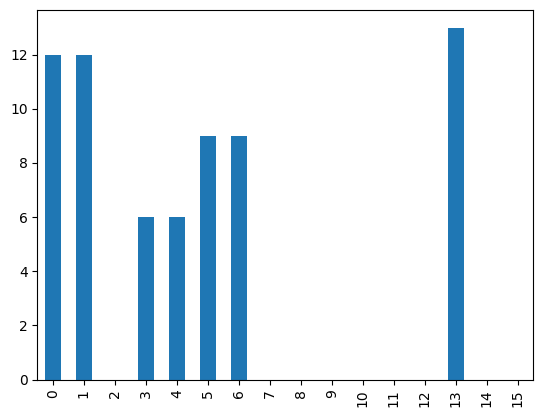

In [30]:
# We can summarise the missing data in a plot
import matplotlib.pyplot as plt
cc_apps.isna().sum().plot(kind='bar')
plt.show()

In [31]:
# As we have little missing data we could in theory just drop the missing data
cc_apps_dropna = cc_apps.dropna()
print(cc_apps_dropna.shape)
# out of 690 we have only lost a small amount so this is probably ok but the guide says to impute them

(653, 16)


# 3. Split the data

Given we have been asked to impute the data we will define a `sklearn.impute.SimpleImputer` to fix our data 
but to avoid leakage we should first we should split our data with `sklearn.model_selection.train_test_split`

In [32]:

cc_apps_train, cc_apps_test = train_test_split(cc_apps, test_size=0.30, random_state=42)

In [33]:
cc_apps_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
178,a,18.42,9.250,u,g,q,v,1.210,t,t,4,f,g,00060,540,+
265,b,17.08,0.085,y,p,c,v,0.040,f,f,0,f,g,00140,722,-
352,b,22.50,11.500,y,p,m,v,1.500,f,f,0,t,g,00000,4000,-
529,b,43.25,25.210,u,g,q,h,0.210,t,t,1,f,g,00760,90,-
409,b,17.08,0.250,u,g,q,v,0.335,f,t,4,f,g,00160,8,-


In [34]:
cc_apps_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
178,a,18.42,9.250,u,g,q,v,1.210,t,t,4,f,g,00060,540,+
265,b,17.08,0.085,y,p,c,v,0.040,f,f,0,f,g,00140,722,-
352,b,22.50,11.500,y,p,m,v,1.500,f,f,0,t,g,00000,4000,-
529,b,43.25,25.210,u,g,q,h,0.210,t,t,1,f,g,00760,90,-
409,b,17.08,0.250,u,g,q,v,0.335,f,t,4,f,g,00160,8,-


In [35]:
# Extract the features and labels into X_train and y_train
X_train = cc_apps_train.iloc[:, :-1].values
y_train = cc_apps_train.iloc[:, -1].values
X_test = cc_apps_test.iloc[:, :-1].values
y_test = cc_apps_test.iloc[:, -1].values


In [36]:
# Look at the indexes and positions
def print_array_details(arr):
    for ci, cv in enumerate(arr):
        print(f'{ci=}  {cv=} {type(cv)}')

In [37]:
print_array_details(cc_apps_train[0])

ci=0  cv='a' <class 'str'>
ci=1  cv='b' <class 'str'>
ci=2  cv='b' <class 'str'>
ci=3  cv='b' <class 'str'>
ci=4  cv='b' <class 'str'>
ci=5  cv='b' <class 'str'>
ci=6  cv='a' <class 'str'>
ci=7  cv='b' <class 'str'>
ci=8  cv='b' <class 'str'>
ci=9  cv='a' <class 'str'>
ci=10  cv='a' <class 'str'>
ci=11  cv='b' <class 'str'>
ci=12  cv=nan <class 'float'>
ci=13  cv='b' <class 'str'>
ci=14  cv='a' <class 'str'>
ci=15  cv='b' <class 'str'>
ci=16  cv='a' <class 'str'>
ci=17  cv='a' <class 'str'>
ci=18  cv='b' <class 'str'>
ci=19  cv='b' <class 'str'>
ci=20  cv='b' <class 'str'>
ci=21  cv='a' <class 'str'>
ci=22  cv='b' <class 'str'>
ci=23  cv=nan <class 'float'>
ci=24  cv='b' <class 'str'>
ci=25  cv='a' <class 'str'>
ci=26  cv='a' <class 'str'>
ci=27  cv='b' <class 'str'>
ci=28  cv='b' <class 'str'>
ci=29  cv='a' <class 'str'>
ci=30  cv='a' <class 'str'>
ci=31  cv='b' <class 'str'>
ci=32  cv='b' <class 'str'>
ci=33  cv='a' <class 'str'>
ci=34  cv='b' <class 'str'>
ci=35  cv='b' <class 'str'

In [ ]:
print_array_details(cc_apps_test[0])

# 4. Handle missing  data

- Impute the missing values contained in the dataset.

Previously we executed this code:

```py
cc_apps = cc_apps.replace('?',np.NaN)
```

to convert source data missing values represented by '?' to numpy Nan (not a number)

We now need to impute the missing data for now the strategy will be:

- convert categorical data missing to most frequent
- convert numerical data missing to the mean

In [38]:
# Missing values are question marks in the source data - converted to NaN
missing_data_columns = [0, 1, 3, 4, 5, 6, 13]

# Define which numeric columns are missing
missing_data_mean=[1] 

# Define which columns with missing data are categorical
missing_data_category=[0, 3, 4, 5, 6, 13]

**Important Notes:**

1. A pipeline runs in parallel and so we need to be careful about which transformers we make use of so they do not impact each other. I found that using `OneHotEncoder` with the `SimpleImputer` caused issues so this just handles imputing 
2. We need to ensure there is no leakage of most frequent or mean between test and train datasets and so we must have a separate `ColumnTransformer` for test and training.

In [39]:
# Import all the packages we need to do the data transforms
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Define the transformations we require for the features
imputing_transformers = transformers = [
    ('imp_mean', SimpleImputer(missing_values=np.NaN, strategy='mean'), missing_data_mean),
    ('imp_freq', SimpleImputer(missing_values=np.NaN, strategy='most_frequent'), missing_data_category)
]

# separate ColumnTransformer
column_imputing_train_tf = ColumnTransformer(transformers=imputing_transformers, remainder='passthrough')
column_imputing_test_tf = ColumnTransformer(transformers=imputing_transformers, remainder='passthrough')

X_train = column_imputing_train_tf.fit_transform(X_train)
X_test = column_imputing_test_tf.fit_transform(X_test)

In [40]:
# Look at the features
print(X_train)
print_array_details(X_train[0])

[[18.42 'a' 'u' ... 'f' 'g' 540]
 [17.08 'b' 'y' ... 'f' 'g' 722]
 [22.5 'b' 'y' ... 't' 'g' 4000]
 ...
 [37.58 'b' 'u' ... 'f' 'p' 0]
 [19.0 'b' 'y' ... 'f' 'g' 1]
 [18.67 'b' 'u' ... 'f' 'g' 38]]
ci=0  cv=18.42 <class 'float'>
ci=1  cv='a' <class 'str'>
ci=2  cv='u' <class 'str'>
ci=3  cv='g' <class 'str'>
ci=4  cv='q' <class 'str'>
ci=5  cv='v' <class 'str'>
ci=6  cv='00060' <class 'str'>
ci=7  cv=9.25 <class 'float'>
ci=8  cv=1.21 <class 'float'>
ci=9  cv='t' <class 'str'>
ci=10  cv='t' <class 'str'>
ci=11  cv=4 <class 'int'>
ci=12  cv='f' <class 'str'>
ci=13  cv='g' <class 'str'>
ci=14  cv=540 <class 'int'>


# 5. Handle categorical data

- Preprocess the data by encoding the categorical features.

Below I define all of the column locations of the different columns.

From the data above we can see what the missing data columns are and what types they are:

In [ ]:
# List all of the columns that are categorical
categorical_data=[1, 2, 3, 4, 5, 6, 9, 10, 12, 13]

Here we convert the '+' and '-' values to a 0 or 1 which we can build our model with

In [41]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [42]:
# Look at the labels
print(y_train)

[0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1
 1 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1
 0 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 1 0
 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0
 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0
 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1
 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1
 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 1 1 1
 1 1 1 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1
 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1
 1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1
 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0
 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0
 1 1]


Now we are ready to convert the categorical data

In [43]:
# Import all the packages we need to do the data transforms
from sklearn.preprocessing import OneHotEncoder

# Define the transformations we require for the features
column_category_tf = ColumnTransformer(transformers=[
        ('encoder', OneHotEncoder(sparse_output=False), categorical_data),
], remainder='passthrough')

X_train = column_category_tf.fit_transform(X_train)

In [44]:
# Look at the features
print(X_train)
print_array_details(X_train[0])

[[1.0 0.0 0.0 ... 1.21 4 540]
 [0.0 1.0 0.0 ... 0.04 0 722]
 [0.0 1.0 0.0 ... 1.5 0 4000]
 ...
 [0.0 1.0 0.0 ... 0.0 0 0]
 [0.0 1.0 0.0 ... 0.0 4 1]
 [0.0 1.0 0.0 ... 0.375 2 38]]
ci=0  cv=1.0 <class 'float'>
ci=1  cv=0.0 <class 'float'>
ci=2  cv=0.0 <class 'float'>
ci=3  cv=1.0 <class 'float'>
ci=4  cv=0.0 <class 'float'>
ci=5  cv=1.0 <class 'float'>
ci=6  cv=0.0 <class 'float'>
ci=7  cv=0.0 <class 'float'>
ci=8  cv=0.0 <class 'float'>
ci=9  cv=0.0 <class 'float'>
ci=10  cv=0.0 <class 'float'>
ci=11  cv=0.0 <class 'float'>
ci=12  cv=0.0 <class 'float'>
ci=13  cv=0.0 <class 'float'>
ci=14  cv=0.0 <class 'float'>
ci=15  cv=0.0 <class 'float'>
ci=16  cv=0.0 <class 'float'>
ci=17  cv=0.0 <class 'float'>
ci=18  cv=1.0 <class 'float'>
ci=19  cv=0.0 <class 'float'>
ci=20  cv=0.0 <class 'float'>
ci=21  cv=0.0 <class 'float'>
ci=22  cv=0.0 <class 'float'>
ci=23  cv=0.0 <class 'float'>
ci=24  cv=0.0 <class 'float'>
ci=25  cv=0.0 <class 'float'>
ci=26  cv=0.0 <class 'float'>
ci=27  cv=0.0 <class